# Following shows the steps of measuring sentiment instability
- before this step, you should already finish the calibration of sentiment labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Reddit/rematch_30_Nov/df_srdd_comments_windowed_valid_labels_rematch.csv' #data of SRDD group
srdd_data = pd.read_csv(file_path, encoding='latin1',lineterminator='\n')

file_path2 = '/content/drive/MyDrive/Reddit/rematch_30_Nov/df_control_comments_windowed_valid_labels_rematch.csv' # data of control group
control_data = pd.read_csv(file_path2, encoding='latin1',lineterminator='\n')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 1. Convert 'created_utc' to DateTime format
srdd_data['created_utc'] = pd.to_datetime(srdd_data['created_utc'], errors='coerce')

# 2. group by 'author', then sort by 'created_utc' within each group
srdd_data_sorted = srdd_data.sort_values(by=['author', 'created_utc'])

# 3. Calculate the time difference (in seconds) within each grouping
srdd_data_sorted['time_diff_minutes'] = srdd_data_sorted.groupby('author')['created_utc'].diff().dt.total_seconds() / 60  # 转换为小时

# 4. limit: 1 to 86400 mins
#srdd_data_sorted['time_diff_minutes'] = srdd_data_sorted['time_diff_minutes'].clip(lower=1, upper=1440)

# 5. fill na rows (for the the first comment) with 0
srdd_data_sorted['time_diff_minutes'] = srdd_data_sorted['time_diff_minutes'].fillna(0)


# srdd_data_sorted['time_diff_seconds'] = np.log1p(srdd_data_sorted['time_diff_seconds'])

srdd_data_sorted




In [ ]:
median_time_diff = srdd_data_sorted.groupby('author')['time_diff_minutes'].median()



In [ ]:
author_counts = srdd_data_sorted.groupby('author').size()
valid_authors = author_counts[author_counts >= 10].index
srdd_data_sorted = srdd_data_sorted[srdd_data_sorted['author'].isin(valid_authors)]

In [ ]:
import pandas as pd
import numpy as np


# 1. compute the sentiment difference
srdd_data_sorted['senti_diff'] = srdd_data_sorted.groupby('author')['predicted_class'].diff().abs()



# 3. compute the weighted sentiment difference
srdd_data_sorted['weighted_senti_diff'] = (
    (srdd_data_sorted['senti_diff'] ** 2) / srdd_data_sorted['time_diff_minutes']
)

# 4. time-adjusted MSSD
def calculate_weighted_mssd(author_data):
    # median value of time difference
    median_time_diff = author_data['time_diff_minutes'].median()

    # time-adjusted MSSD for each user
    weighted_mssd = np.sum(author_data['weighted_senti_diff']) / (len(author_data) - 1)

    # weight setting
    weighted_mssd *= median_time_diff

    return weighted_mssd

# 5. for each user, get the final result
user_weighted_mssd = srdd_data_sorted.groupby('author').apply(calculate_weighted_mssd)


user_weighted_mssd


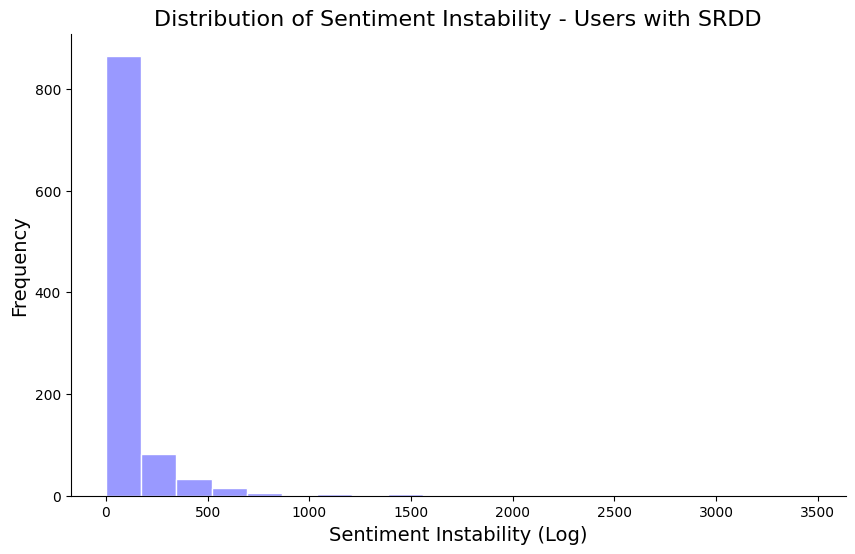

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of sentiment instability
plt.figure(figsize=(10, 6))
sns.histplot(user_weighted_mssd, kde=False, bins=20, color='blue',edgecolor = 'white', alpha = 0.4)
sns.despine()


plt.title('Distribution of Sentiment Instability - Users with SRDD', fontsize=16)
plt.xlabel('Sentiment Instability (Log)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
user_weighted_mssd.to_csv('/content/drive/MyDrive/Reddit/rematch_30_Nov/srdd_author_instability_rematch.csv', index = True)

# **same process for control users**

In [ ]:
# same process for control users


control_data['created_utc'] = pd.to_datetime(control_data['created_utc'], errors='coerce')

control_data

In [ ]:
# 2. group by 'author', then sort by 'created_utc' within each group
control_data_sorted = control_data.drop_duplicates().sort_values(by=['author_id', 'created_utc'])
author_counts = control_data_sorted.groupby('author_id').size()
valid_authors = author_counts[author_counts >= 10].index
control_data_sorted = control_data_sorted[control_data_sorted['author_id'].isin(valid_authors)]

In [ ]:
# 3. time difference
control_data_sorted['time_diff_minutes'] = control_data_sorted.groupby('author_id')['created_utc'].diff().dt.total_seconds() / 60  # 转换为分钟


In [ ]:

# 4. limit the time difference
#control_data_sorted['time_diff_minutes'] = control_data_sorted['time_diff_minutes'].clip(lower=1, upper=1440)

# 5. fill in na with 0
control_data_sorted['time_diff_minutes'] = control_data_sorted['time_diff_minutes'].fillna(0)

# control_data_sorted['time_diff_seconds'] = np.log1p(control_data_sorted['time_diff_seconds'])
# median_time_diff_control = control_data_sorted.groupby('author_id')['time_diff_minutes'].median()

control_data_sorted['senti_diff'] = control_data_sorted.groupby('author_id')['predicted_class'].diff().abs()

control_data_sorted['weighted_senti_diff'] = (
    (control_data_sorted['senti_diff'] ** 2) / control_data_sorted['time_diff_minutes']
)
control_data_sorted['weighted_senti_diff'] = control_data_sorted['weighted_senti_diff'].fillna(0)


def calculate_weighted_mssd(author_data):
    # median of the time difference
    median_time_diff = author_data['time_diff_minutes'].median()

    # weighted MSSD
    weighted_mssd = np.sum(author_data['weighted_senti_diff']) / (len(author_data) - 1)
    # time difference is considered
    weighted_mssd *= median_time_diff

    return weighted_mssd

user_weighted_mssd_control = control_data_sorted.groupby('author_id').apply(calculate_weighted_mssd)

user_weighted_mssd_control

In [ ]:
user_weighted_mssd_control.to_csv('/content/drive/MyDrive/Reddit/rematch_30_Nov/control_author_instability_rematch.csv', index = True)

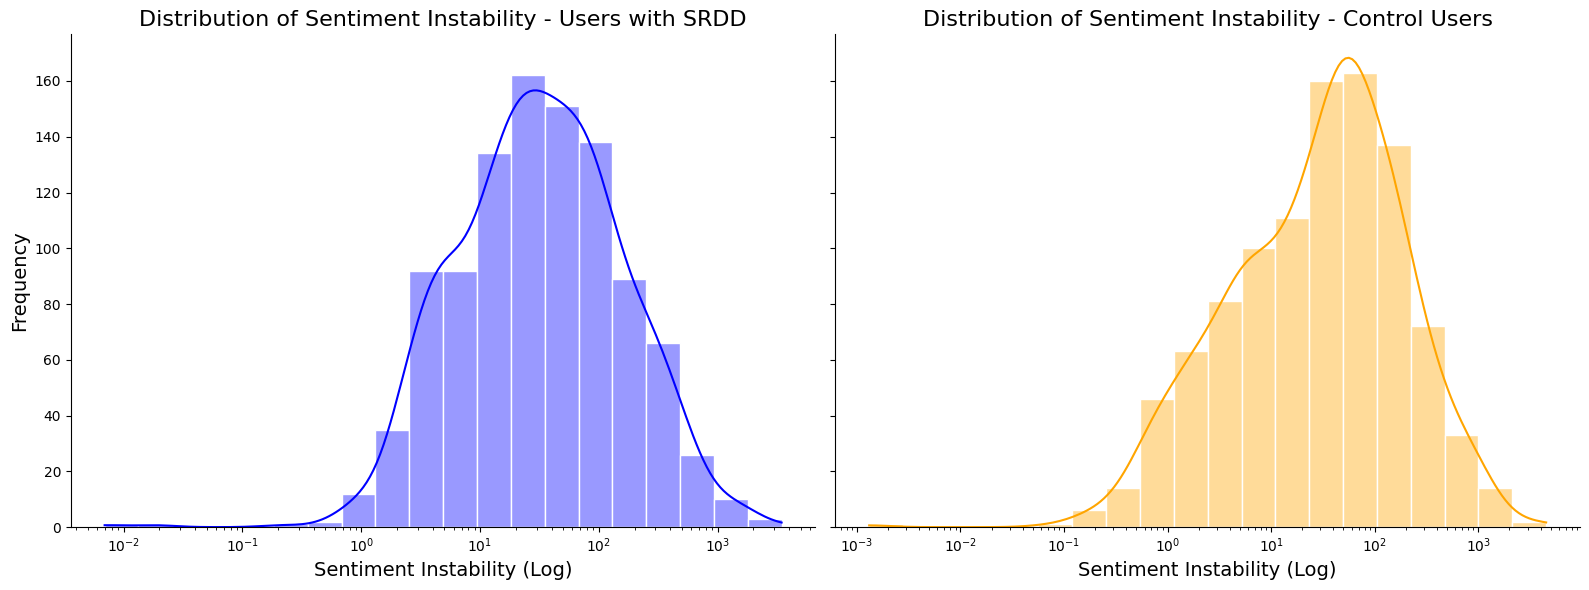

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1x2 layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# SRDD group
sns.histplot(user_weighted_mssd, kde=True, bins=20, color='blue', edgecolor='white', alpha=0.4, log_scale=True, ax=axes[0])
sns.despine(ax=axes[0])
axes[0].set_title('Distribution of Sentiment Instability - Users with SRDD', fontsize=16)
axes[0].set_xlabel('Sentiment Instability (Log)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

# Control group
sns.histplot(user_weighted_mssd_control, kde=True, bins=20, color='orange', edgecolor='white', alpha=0.4, log_scale=True, ax=axes[1])
sns.despine(ax=axes[1])
axes[1].set_title('Distribution of Sentiment Instability - Control Users', fontsize=16)
axes[1].set_xlabel('Sentiment Instability (Log)', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# statistical testing of sentiment instability

import scipy.stats as stats

# normal distribution check
stat_mssd, p_mssd = stats.shapiro(user_weighted_mssd)
stat_mssd_control, p_mssd_control = stats.shapiro(user_weighted_mssd_control)

print(f"Shapiro-Wilk test for user_weighted_mssd: stat={stat_mssd}, p={p_mssd}")
print(f"Shapiro-Wilk test for user_weighted_mssd_control: stat={stat_mssd_control}, p={p_mssd_control}")

# if not normal, Mann-Whitney U test is adopted

if p_mssd < 0.05 or p_mssd_control < 0.05:
    # Mann-Whitney U
    u_stat, u_p_value = stats.mannwhitneyu(user_weighted_mssd, user_weighted_mssd_control, alternative='two-sided')
    print(f"Mann-Whitney U test: stat={u_stat}, p={u_p_value}")
else:
    # if normal, t test is adopted
    t_stat, t_p_value = stats.ttest_ind(user_weighted_mssd, user_weighted_mssd_control, equal_var=False)
    print(f"Independent t-test: stat={t_stat}, p={t_p_value}")


Shapiro-Wilk test for user_weighted_mssd: stat=0.4230702250839724, p=7.211612489684157e-49
Shapiro-Wilk test for user_weighted_mssd_control: stat=0.38369017618251744, p=1.0182835004947547e-49
Mann-Whitney U test: stat=521353.0, p=0.36670615359435077


In [ ]:
t_stat, t_p_value = stats.ttest_ind(user_weighted_mssd, user_weighted_mssd_control,equal_var=False)
print(f"Independent t-test: stat={t_stat}, p={t_p_value}")

Independent t-test: stat=-1.0141153510329528, p=0.3106543719269046


In [ ]:
import numpy as np
import scipy.stats as stats

# descriptive stats
def calculate_statistics(data):
    median = np.median(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return median, mean, std_dev, iqr

# srdd group and contro group
stats_group1 = calculate_statistics(user_weighted_mssd)
stats_group2 = calculate_statistics(user_weighted_mssd_control)

print("Group 1 (User Weighted MSSD):")
print(f"  Median: {stats_group1[0]}")
print(f"  Mean: {stats_group1[1]}")
print(f"  Standard Deviation: {stats_group1[2]}")
print(f"  Interquartile Range (IQR): {stats_group1[3]}")

print("\nGroup 2 (User Weighted MSSD Control):")
print(f"  Median: {stats_group2[0]}")
print(f"  Mean: {stats_group2[1]}")
print(f"  Standard Deviation: {stats_group2[2]}")
print(f"  Interquartile Range (IQR): {stats_group2[3]}")

# Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(user_weighted_mssd, user_weighted_mssd_control, alternative='two-sided')

print("\nMann-Whitney U Test:")
print(f"  U Statistic: {u_statistic}")
print(f"  P-value: {p_value}")
if p_value < 0.05:
    print("  Result: Significant difference between the two groups (p < 0.05).")
else:
    print("  Result: No significant difference between the two groups (p >= 0.05).")


Group 1 (User Weighted MSSD):
  Median: 31.096803310225553
  Mean: 101.43875339217487
  Standard Deviation: 224.404346810309
  Interquartile Range (IQR): 83.68417561662604

Group 2 (User Weighted MSSD Control):
  Median: 34.93644962329702
  Mean: 112.71776117481123
  Standard Deviation: 272.73152359648844
  Interquartile Range (IQR): 102.36930132404488

Mann-Whitney U Test:
  U Statistic: 521353.0
  P-value: 0.36670615359435077
  Result: No significant difference between the two groups (p >= 0.05).
